In [98]:
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as md
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import warnings
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import interp2d
warnings.filterwarnings('ignore')
#import datetime
import scipy.ndimage as ndimage
from matplotlib import cm
import geopy.distance
#import matplotlib as mpl

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import leafmap
import plotly.express as px

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
#import pysplit

In [2]:
def read_traj(path):
    with open(path) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    # Check if the content list is empty
    if len(content) == 0:
        return None
    
    skiprows = int(content[0].split(' ')[0]) + 4
    traj = pd.read_csv(path, skiprows=skiprows, header=None, delim_whitespace=True)
    
    # Check if the traj DataFrame is empty
    if traj.empty:
        return None
    
    traj = traj.iloc[:, 2:]
    traj.columns = ['Year', 'Month', 'Day', 'Hour', 'Min', '',
                    'Timestep', 'Latitude', 'Longitude', 'Altitude_AGL_m',
                    'Pressure_mb', 'tpot', 'tamb',
                    'rain', 'mixd', 'relh', 'sphu',
                    'mixr', 'dswf', 'terr']
    
    # Check if there are rows in the traj DataFrame
    if traj.shape[0] == 0:
        return None
    
    traj['Launch_UTC'] = pd.to_datetime(f'{traj.Year.iloc[0].astype(str)}'
                                        f'{traj.Month.iloc[0].astype(str).zfill(2)}'
                                        f'{traj.Day.iloc[0].astype(str).zfill(2)}'
                                        f'{traj.Hour.iloc[0].astype(str).zfill(2)}'
                                        f'{traj.Min.iloc[0].astype(str).zfill(2)}',
                                        format='%y%m%d%H%M')
    traj.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Min', ''], inplace=True)
    traj['Launch_Altitude_AGL_m'] = traj.Altitude_AGL_m[0]
    return traj

In [41]:
df1 = read_traj('C:/Users/taiwoajayi/Documents/ACTIVATE_B_P_GFS_72h/ACTIVATE_B_P_GFS_72h_202206021123')
df1
#"C:\Users\taiwoajayi\Documents\ACTIVATE_B_P_GFS_72h\ACTIVATE_B_P_GFS_72h_202206021123"

,Timestep,Latitude,Longitude,Altitude_AGL_m,Pressure_mb,tpot,tamb,rain,mixd,relh,sphu,mixr,dswf,terr,Launch_UTC,Launch_Altitude_AGL_m
0,0.0,32.437,-64.956,1531.6,848.7,300.8,287.0,0.0,646.9,71.6,8.3,8.4,0.0,79.4,2022-06-02 11:23:00,1531.6
1,-0.4,32.442,-65.065,1501.1,851.7,300.7,287.2,0.0,643.6,72.6,8.4,8.6,0.0,66.7,2022-06-02 11:23:00,1531.6
2,-1.4,32.440,-65.350,1404.4,861.6,300.3,287.8,0.1,702.5,70.7,8.5,8.6,0.0,33.2,2022-06-02 11:23:00,1531.6
3,-2.4,32.426,-65.638,1305.4,869.9,299.9,288.2,0.2,739.0,72.8,8.9,9.0,0.0,0.0,2022-06-02 11:23:00,1531.6
4,-3.4,32.403,-65.924,1203.6,883.7,299.3,288.9,0.0,748.6,74.6,9.3,9.5,0.0,0.0,2022-06-02 11:23:00,1531.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,-67.4,31.704,-71.366,1097.5,899.5,299.1,290.1,0.3,365.1,70.3,9.4,9.5,0.0,640.6,2022-06-02 11:23:00,1531.6
69,-68.4,31.676,-71.376,1102.4,898.8,299.1,290.1,0.0,264.1,70.8,9.4,9.5,0.0,589.7,2022-06-02 11:23:00,1531.6
70,-69.4,31.648,-71.392,1100.0,898.2,299.1,290.1,0.3,299.6,70.2,9.3,9.5,0.0,409.2,2022-06-02 11:23:00,1531.6
71,-70.4,31.612,-71.418,1082.9,899.9,299.1,290.2,0.0,327.6,70.0,9.3,9.5,0.0,228.8,2022-06-02 11:23:00,1531.6


In [27]:
# Get a list of all file paths matching the glob pattern
file_paths = glob.glob('/Users/taiwoajayi/Documents/ACTIVATE_B_P_GFS_72h'+'/*ACTIVATE*20220602*')  # Replace 'path_to_files' with the actual path and glob pattern

# Initialize an empty list to store the individual DataFrames
dfs = []

# Iterate over each file path
for file_path in file_paths:
    # Read each file as a DataFrame using the read_traj() function
    df = read_traj(file_path)
    
    # Check if the DataFrame is empty
    if df is not None:
        # Append the DataFrame to the list
        dfs.append(df)

# Check if there are DataFrames in the list
if len(dfs) > 0:
    # Concatenate all DataFrames in the list into one DataFrame
    merged_df = pd.concat(dfs, ignore_index=True)
    # Reorder the columns
    new_order = ['Launch_UTC', 'Timestep', 'Latitude', 'Longitude', 'Launch_Altitude_AGL_m', 'Altitude_AGL_m', 'Pressure_mb','tpot','tamb', 'rain', 'mixd', 'relh', 'sphu' 'mixr', 'dswf', 'terr']
    merged_df = merged_df.reindex(columns=new_order)
    print(merged_df)
    
    # Save the merged DataFrame to a file named "merge.csv"
    #merged_df.to_csv('merge.csv', index=False)
else:
    print("No valid dataframes to merge.")


               Launch_UTC  Timestep  Latitude  Longitude   
0     2022-06-02 11:23:00       0.0    32.437    -64.956  \
1     2022-06-02 11:23:00      -0.4    32.442    -65.065   
2     2022-06-02 11:23:00      -1.4    32.440    -65.350   
3     2022-06-02 11:23:00      -2.4    32.426    -65.638   
4     2022-06-02 11:23:00      -3.4    32.403    -65.924   
...                   ...       ...       ...        ...   
25983 2022-06-02 19:01:00     -67.0    31.791    -69.200   
25984 2022-06-02 19:01:00     -68.0    31.762    -69.224   
25985 2022-06-02 19:01:00     -69.0    31.740    -69.242   
25986 2022-06-02 19:01:00     -70.0    31.725    -69.257   
25987 2022-06-02 19:01:00     -71.0    31.708    -69.271   

       Launch_Altitude_AGL_m  Altitude_AGL_m  Pressure_mb   tpot   tamb  rain   
0                     1531.6          1531.6        848.7  300.8  287.0   0.0  \
1                     1531.6          1501.1        851.7  300.7  287.2   0.0   
2                     1531.6        

In [28]:
merged_df

,Launch_UTC,Timestep,Latitude,Longitude,Launch_Altitude_AGL_m,Altitude_AGL_m,Pressure_mb,tpot,tamb,rain,mixd,relh,sphumixr,dswf,terr
0,2022-06-02 11:23:00,0.0,32.437,-64.956,1531.6,1531.6,848.7,300.8,287.0,0.0,646.9,71.6,NaN,0.0,79.4
1,2022-06-02 11:23:00,-0.4,32.442,-65.065,1531.6,1501.1,851.7,300.7,287.2,0.0,643.6,72.6,NaN,0.0,66.7
2,2022-06-02 11:23:00,-1.4,32.440,-65.350,1531.6,1404.4,861.6,300.3,287.8,0.1,702.5,70.7,NaN,0.0,33.2
3,2022-06-02 11:23:00,-2.4,32.426,-65.638,1531.6,1305.4,869.9,299.9,288.2,0.2,739.0,72.8,NaN,0.0,0.0
4,2022-06-02 11:23:00,-3.4,32.403,-65.924,1531.6,1203.6,883.7,299.3,288.9,0.0,748.6,74.6,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25983,2022-06-02 19:01:00,-67.0,31.791,-69.200,6.3,16.9,1018.1,296.4,297.9,0.0,515.6,71.5,NaN,0.0,389.4
25984,2022-06-02 19:01:00,-68.0,31.762,-69.224,6.3,16.9,1018.4,296.3,297.9,0.0,528.1,71.7,NaN,0.0,476.0
25985,2022-06-02 19:01:00,-69.0,31.740,-69.242,6.3,16.9,1018.7,296.3,297.9,0.0,515.7,71.9,NaN,0.0,563.1
25986,2022-06-02 19:01:00,-70.0,31.725,-69.257,6.3,16.9,1019.0,296.3,297.9,0.0,497.4,72.1,NaN,0.0,649.4


In [29]:
list(merged_df)

['Launch_UTC',
 'Timestep',
 'Latitude',
 'Longitude',
 'Launch_Altitude_AGL_m',
 'Altitude_AGL_m',
 'Pressure_mb',
 'tpot',
 'tamb',
 'rain',
 'mixd',
 'relh',
 'sphumixr',
 'dswf',
 'terr']

In [36]:
start_index = np.where(merged_df['Launch_UTC']==pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(merged_df['Launch_UTC']==pd.to_datetime("2022-06-02 14:10:00"))   
merged_df2_subset = merged_df[start_index[0][0]:stop_index[0][0]]
merged_df2_subset

,Launch_UTC,Timestep,Latitude,Longitude,Launch_Altitude_AGL_m,Altitude_AGL_m,Pressure_mb,tpot,tamb,rain,mixd,relh,sphumixr,dswf,terr
10585,2022-06-02 13:48:00,0.0,32.388,-65.874,1906.7,1906.7,812.2,303.4,285.9,0.1,672.8,35.9,NaN,0.0,487.3
10586,2022-06-02 13:48:00,-0.8,32.375,-66.057,1906.7,1865.4,816.1,303.2,286.0,0.1,675.3,38.7,NaN,0.0,314.7
10587,2022-06-02 13:48:00,-1.8,32.355,-66.290,1906.7,1824.9,820.0,302.9,286.2,0.2,684.1,37.3,NaN,0.0,95.4
10588,2022-06-02 13:48:00,-2.8,32.332,-66.533,1906.7,1789.5,823.0,302.6,286.2,0.0,672.0,46.3,NaN,0.0,61.3
10589,2022-06-02 13:48:00,-3.8,32.309,-66.774,1906.7,1760.4,825.9,302.2,286.1,0.0,657.4,58.1,NaN,0.0,30.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12186,2022-06-02 14:09:00,-67.2,34.920,-70.128,2752.6,4460.3,597.4,314.3,271.2,0.0,562.4,28.3,NaN,0.0,813.1
12187,2022-06-02 14:09:00,-68.2,34.990,-70.210,2752.6,4460.6,597.4,314.2,271.2,0.0,548.0,29.4,NaN,0.0,847.6
12188,2022-06-02 14:09:00,-69.2,35.063,-70.303,2752.6,4475.0,597.2,314.1,271.1,0.0,527.3,29.8,NaN,0.0,802.1
12189,2022-06-02 14:09:00,-70.2,35.139,-70.414,2752.6,4517.1,593.8,314.2,270.6,0.0,501.4,30.0,NaN,0.0,753.8


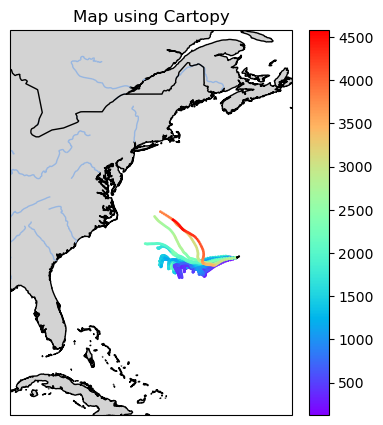

In [113]:
# Create a figure and an axes with a specific projection
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax.set_aspect('auto', adjustable='box')

# Customize the map projection and extent
ax.set_extent([-85, -60, 20, 50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

# Add additional map features, such as rivers, borders, or land color
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Optionally, plot data or markers on the map
#plt.scatter(x, y, c=colors, cmap='RdYlGn', s=100)
norm = plt.Normalize(0, 3000)
sc = ax.scatter(merged_df2_subset['Longitude'], merged_df2_subset['Latitude'], c=merged_df2_subset['Altitude_AGL_m'], cmap='rainbow', s=1, transform=ccrs.PlateCarree())
#ax.plot(df1['Longitude'], df1['Latitude'], c=df1['Launch_Altitude_AGL_m'], cmap='rainbow', transform=ccrs.PlateCarree())  # Example marker
cbar = plt.colorbar(sc)



# Set the title of the map
ax.set_title('Map using Cartopy')
plt.subplots_adjust(hspace=0)

# Show the map
plt.show()


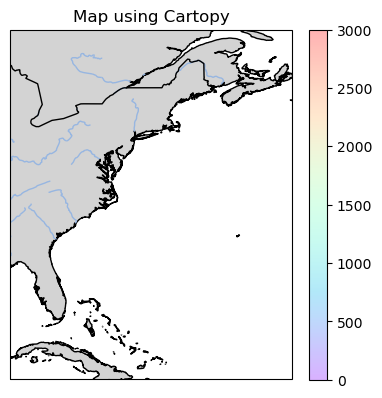

In [112]:

# Create a figure and an axes with a specific projection
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax.set_aspect('auto', adjustable='box')

# Customize the map projection and extent
ax.set_extent([-85, -60, 20, 50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

# Add additional map features, such as rivers, borders, or land color
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Optionally, plot data or markers on the map
#plt.scatter(x, y, c=colors, cmap='RdYlGn', s=100)
norm = plt.Normalize(0, 3000)
points = np.array(merged_df2_subset['Longitude'], merged_df2_subset['Latitude']).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='rainbow', norm=norm, alpha=0.3)
lc.set_array(merged_df2_subset['Launch_Altitude_AGL_m'])
lc.set_linewidth(2)
line = ax.add_collection(lc)
#sc = ax.scatter(df1['Longitude'], df1['Latitude'], c=df1['Launch_Altitude_AGL_m'], norm=norm, cmap='rainbow', s=100, transform=ccrs.PlateCarree())
#ax.plot(df1['Longitude'], df1['Latitude'], c=df1['Launch_Altitude_AGL_m'], cmap='rainbow', transform=ccrs.PlateCarree())  # Example marker
cbar = plt.colorbar(line)


# Set the title of the map
ax.set_title('Map using Cartopy')

# Show the map
plt.show()

In [ ]:
 ax_map = ax[x, y]

    ax_map.set_aspect('auto', adjustable='box')

    ax_map.set_extent([-90., -60., 20., 50.], crs=ccrs.PlateCarree())

    ax_map.coastlines(resolution='10m')

    day = sum2[acc]
    for i in range(len(day)):
        d = day[i]
        points = np.array([d[10], d[9]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(0, 7000)
        lc = LineCollection(segments, cmap='rainbow', norm=norm, alpha=0.3)
        lc.set_array(d[11])
        lc.set_linewidth(2)
        line = ax_map.add_collection(lc)
        cb = plt.colorbar(line, ax=ax_map)

In [ ]:
# Create a new figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(16, 4), subplot_kw={'projection': ccrs.PlateCarree()})

# Define the map extents for each subplot
extents = [
    (-90, -60, 20, 50),    # Subplot 1
    (-90, -60, 20, 50),       # Subplot 2
    (-90, -60, 20, 50),        # Subplot 3
    (-90, -60, 20, 50),      # Subplot 4
    (-90, -60, 20, 50),     # Subplot 5
    (-90, -60, 20, 50),        # Subplot 6
    (-90, -60, 20, 50),         # Subplot 7
    (-90, -60, 20, 50),      #subplot 8
    (-90, -60, 20, 50),    # Subplot 9
    (-90, -60, 20, 50),       # Subplot 10
    (-90, -60, 20, 50),        # Subplot 11
    (-90, -60, 20, 50),      # Subplot 12
    (-90, -60, 20, 50),     # Subplot 13
    (-90, -60, 20, 50)        # Subplot 14
]

# Add map features and plot data to each subplot
for i, ax in enumerate(axes.flatten()):
    ax.set_extent(extents[i], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
 # Example marker

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
